In [1]:
import torch
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

%matplotlib inline

In [2]:
# The tokenizer will remove spaces so remove them for the labels and ensure they are real words.
labels = ["Fake", "Real"]

label_folders = {
    "Fake": "fake",
    "Real": "real"
}

dataset_folder = "/Users/akash/Code/car_images/dataset"

In [ ]:
import os
import math
import PIL.Image
from glob import glob


prompt = "Classify the following image into exactly one of " + ", ".join([f"'{label}'" for label in labels])

def load_realwaste(path, sample_per_label = 200, training_percent = 0.9):
    if not os.path.isdir(path):
        raise Exception(f"{path} path does not exist")
    
    label_dict = {}

    for label in labels:
        label_dict[label] = []
        for file in glob(os.path.join(path, label_folders[label], "*.jpg")):
            label_dict[label].append(file)
    
    train_ds = []
    eval_ds = []
    train_count = math.floor(sample_per_label * training_percent)
    test_count = math.floor((sample_per_label - train_count) / 2)

    for label in labels:
        files = label_dict[label]

        training_data = [{"id": file, "image": PIL.Image.open(f"{file}").resize((224, 224)), "label": label} for file in files[:train_count]]
        eval_data = [{"id": file, "image": PIL.Image.open(f"{file}").resize((224, 224)), "label": label} for file in files[train_count: train_count + test_count]]

        train_ds.extend(training_data)
        eval_ds.extend(eval_data)

    return train_ds, eval_ds, pd.DataFrame(train_ds), pd.DataFrame(eval_ds)

train_ds, eval_ds, train_df, eval_df = load_realwaste(dataset_folder)
display(train_df)
display(eval_df)

,id,image,label
0,/Users/akash/Code/car_images/dataset/fake/niss...,<PIL.Image.Image image mode=RGB size=224x224 a...,Fake
1,/Users/akash/Code/car_images/dataset/fake/niss...,<PIL.Image.Image image mode=RGB size=224x224 a...,Fake
2,/Users/akash/Code/car_images/dataset/fake/toyo...,<PIL.Image.Image image mode=RGB size=224x224 a...,Fake
3,/Users/akash/Code/car_images/dataset/fake/tesl...,<PIL.Image.Image image mode=RGB size=224x224 a...,Fake
4,/Users/akash/Code/car_images/dataset/fake/tesl...,<PIL.Image.Image image mode=RGB size=224x224 a...,Fake
...,...,...,...
95,/Users/akash/Code/car_images/dataset/real/chev...,<PIL.Image.Image image mode=RGB size=224x224 a...,Real
96,/Users/akash/Code/car_images/dataset/real/bmw_...,<PIL.Image.Image image mode=RGB size=224x224 a...,Real
97,/Users/akash/Code/car_images/dataset/real/bmw_...,<PIL.Image.Image image mode=RGB size=224x224 a...,Real
98,/Users/akash/Code/car_images/dataset/real/chev...,<PIL.Image.Image image mode=RGB size=224x224 a...,Real


""


Fake samples


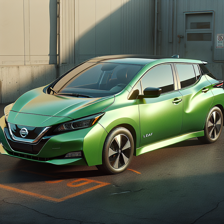

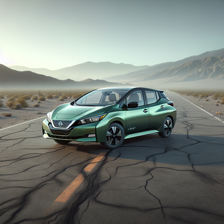

In [26]:
print("Fake samples")
for image in train_df[( train_df["label"] == "Fake")].iloc[:min(2, len(images))]["image"]:
    display(image)

Real samples


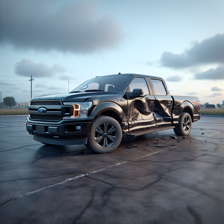

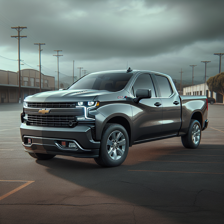

In [25]:
print("Real samples")
for image in train_df[( train_df["label"] == "Real")].iloc[:min(2, len(images))]["image"]:
    display(image)

In [4]:
processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False, resume_download=None)

processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.jinja' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
    )

lora_config = LoraConfig(
    r=16,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
    use_dora=False,
    init_lora_weights="gaussian"
    )

model = Idefics2ForConditionalGeneration.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
    low_cpu_mem_usage = True,
    resume_download = None,
    )

model = get_peft_model(model, lora_config)
model

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

ImportError: The installed version of bitsandbytes (<0.43.1) requires CUDA, but CUDA is not available. You may need to install PyTorch with CUDA support or upgrade bitsandbytes to >=0.43.1.

In [14]:
def data_collator(processor, samples):
    texts = []
    images = []

    image_token_id = processor.tokenizer.additional_special_tokens_ids[processor.tokenizer.additional_special_tokens.index("<image>")]

    for sample in samples:
        image = sample["image"]
        label = sample["label"]

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image"},
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": label}
                ]
            }
        ]

        text = processor.apply_chat_template(messages, add_generation_prompt=False)
        texts.append(text.strip())
        images.append([image])

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    batch_labels = batch["input_ids"].clone()
    batch_labels[batch_labels == processor.tokenizer.pad_token_id] = image_token_id
    batch["labels"] = batch_labels

    return batch


def compute_metrics(processor, pred):
    batch_labels = []
    for label_id_batch in pred.label_ids:
        for label_id in label_id_batch:
            label = processor.batch_decode(label_id, skip_special_tokens=True)
            label = "".join(label).split("Assistant:")[-1].strip()
            batch_labels.append(label)

    bad_prediction_count = 0
    bad_predictions = {}
    predictions = []
    i = 0
    for prediction_batch in pred.predictions:
        for prediction_tensor in prediction_batch[0]:
            prediction_id = prediction_tensor.argmax(-1)
            prediction_answer = processor.batch_decode(prediction_id, skip_special_tokens=True)
            prediction = "".join(prediction_answer).split("Assistant:")[-1].strip()
            predictions.append(prediction)
            
            if not prediction in labels:
                bad_prediction_count += 1
                label = batch_labels[i]
                if not label in bad_predictions:
                    bad_predictions[label] = [prediction]
                else:
                    bad_predictions[label].append(prediction)
            
            i += 1
            

    accuracy = accuracy_score(batch_labels, predictions)
    precision = precision_score(batch_labels, predictions, average='weighted', zero_division=0.0)
    recall = recall_score(batch_labels, predictions, average='weighted', zero_division=0.0)

    print(f"Bad predictions:\n{bad_predictions}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "bad_predictions": bad_prediction_count
    }


training_args = TrainingArguments(
    num_train_epochs = 2,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 10,
    gradient_checkpointing = True,
    gradient_checkpointing_kwargs={'use_reentrant':False},
    warmup_steps = 50,
    learning_rate = 1e-4,
    weight_decay = 0.01,
    logging_steps = 10,
    logging_strategy = "steps",
    save_strategy = "steps",
    save_steps = 10,
    save_total_limit = 100,
    eval_do_concat_batches = False,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    overwrite_output_dir = True,
    fp16 = True,
    remove_unused_columns=False,
    report_to = "none",
    eval_strategy = "steps",
    eval_steps = 10,
    output_dir = "checkpoints",
    log_level = "info",
    label_names = ["labels"],
)

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = lambda samples: data_collator(processor, samples),
    train_dataset = train_ds,
    eval_dataset = eval_ds,
    compute_metrics = lambda predictions: compute_metrics(processor, predictions),
)

NameError: name 'model' is not defined

In [7]:
model.config.use_cache=False
trainer.train()
model.config.use_cache = True

NameError: name 'model' is not defined

In [8]:
def compute_inference_metrics(df_cm, y_true):
    metrics = []
    total_tp_tn = 0

    for label in set(y_true):
        df_label = df_cm.loc[[label]]
        tp = df_label[label].iloc[0]
        fp = df_label.sum(axis=1).iloc[0] - tp
        fn = df_cm[label].sum() - tp
        total_tp_tn += tp

        precision = tp / (tp+fp)
        recall = tp / (tp+fn)

        metrics.append({"label": label, "precision": precision, "recall": recall})

    accuracy = (total_tp_tn / len(y_true)) * 100
    df_metrics = pd.DataFrame(metrics)
    df_metrics.set_index("label")

    return df_metrics, accuracy


def infer_model(processor, model, image):
    messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image"},
                ]
            },       
        ]

    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=input_text, images=[image], return_tensors="pt")
    inputs = {k: v.cuda() for k, v in inputs.items()}

    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return generated_texts[0].split("Assistant:")[-1].strip()


def evaluate_model(processor, model, eval_dataset):
    model.eval()

    y_true = []
    y_pred = []
    images = []
    
    bad_prediction_count = 0
    bad_predictions = {}

    for sample in eval_dataset:
        image = sample["image"]
        label = sample["label"]

        prediction = infer_model(processor, model, image)

        y_true.append(label)
        y_pred.append(prediction)
        images.append(image)

        if not prediction in labels:
            bad_prediction_count += 1
            if not label in bad_predictions:
                bad_predictions[label] = [prediction]
            else:
                bad_predictions[label].append(prediction)

    labels_set = sorted(set(y_true))
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels_set)

    df_metrics, accuracy = compute_inference_metrics(df_cm, y_true)

    return y_true, y_pred, images, df_cm, df_metrics, accuracy, bad_prediction_count, bad_predictions


def display_sample_failures(df, label, prediction):
    images = df[(df["Label"] == label) & (df["Prediction"] == prediction)]["Image"]
    print(f"Found {len(images)} samples with label '{label}' and prediction '{prediction}'")

    for i in range(min(5, len(images))):
        display(images.iloc[i])

In [9]:
y_true, y_pred, images, df_cm, df_metrics, accuracy, bad_prediction_count, bad_predictions = evaluate_model(processor, model, eval_ds)
df_results = pd.DataFrame(zip(y_true, y_pred, images), columns=["Label", "Prediction", "Image"])

print(f"Accuracy:\t\t{accuracy:.2f}")
print(f"Bad Predictions:\t{bad_prediction_count}/{len(y_true)}")
print(bad_predictions)

plt.figure()
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()
display(df_cm)

display(df_metrics)

NameError: name 'model' is not defined

In [10]:
display_sample_failures(df_results, label="Miscellaneous", prediction="Paper")

NameError: name 'df_results' is not defined